__NOTES__

Should do clusters separately for light and dark conditions...

Anaplerotic reactions in Dokdonia:

![rxns](Papers/anaplerotic_rxns_dokdonia.jpeg)

1. Pyruvate carboxylase: MED134_06244
2. PEP carboxylase: MED134_06089
3. PEP carboxykinase (ATP): MED134_10331
4. Malic enzyme: MED134_11446

https://www.nature.com/articles/ismej201136

https://journals.asm.org/doi/10.1128/aem.06152-11?permanently=true&

Pyruvate carboxylase and PEP carboxykinase follow pattern C6 although not included by clust.


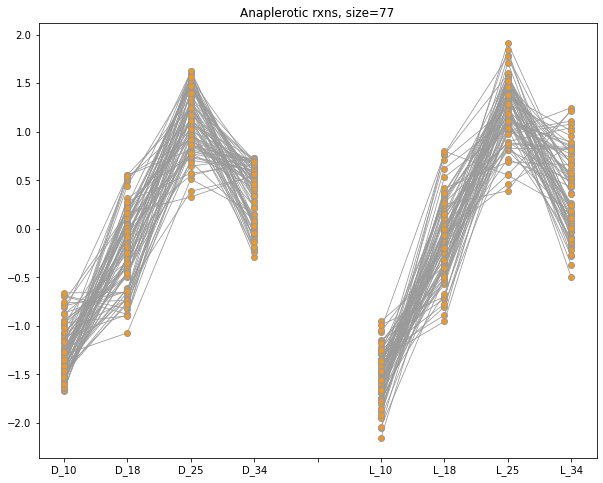

In [27]:
anaplerotic_rxns = {'Pyruvate carboxylase': 'MED134_06244', 'PEP carboxylase': 'MED134_06089',
                   'PEP carboxykinase (ATP) [4.1.1.49]': 'MED134_10331', 'Malic enzyme': 'MED134_11446'}

for cluster_id, cluster in clusters['TC'].items():
    for rxn_id, locus_tag in anaplerotic_rxns.items():
        if locus_tag in cluster:
            print(f'{rxn_id} ({locus_tag}) in cluter: {cluster_id}')
            
ax = plt.gca()
ax.figure.set_size_inches(10, 8)
# list(anaplerotic_rxns.values())
Dc.plotClusterData(cluster_data['TC'], ['MED134_06244', 'MED134_10331'] + clusters['TC']['C6'], ax, 'Anaplerotic rxns')
plt.show()

In [1]:
import pandas as pd
import numpy as np
import os
import json
import copy
from matplotlib import pyplot as plt
from matplotlib_venn import venn2
import Dokdonia_code as Dc
# plt.style.use('plt_styles.mplstyle')
%matplotlib inline

# Analysis of differential expression

In [19]:
# Loading counts and removing genes with low read counts across samples
min_count = 10

counts = pd.read_csv('Data/DokdoniaCounts.csv', index_col=0)
counts = counts[counts.filter(regex='^[^T]+$').columns]
conditions = [name.split('.sam')[0] for name in counts.columns]
counts.columns = conditions
counts = counts[(counts > min_count).all(1)]
counts.reset_index(level=0, inplace=True)
counts.head()

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


,index,D_10_R1,D_10_R2,D_10_R3,D_18_R1,D_18_R2,D_18_R3,D_18_R4,D_25_R1,D_25_R2,...,L_18_R2,L_18_R3,L_18_R4,L_25_R1,L_25_R2,L_25_R3,L_34_R1,L_34_R2,L_34_R3,L_34_R4
0,MED134_07389,12973,11426,13251,30624,30618,41014,22449,53840,32369,...,16255,23945,20102,39444,41721,37020,39662,30983,27280,57834
1,MED134_07384,1557,1555,1552,4160,4385,5588,2940,7550,4509,...,2564,3003,2894,5419,5536,5318,5396,4751,4285,7818
2,MED134_07379,3400,3319,3273,7218,7903,9539,5040,13268,7572,...,4575,5361,4923,9089,9016,8529,10179,7617,7207,13827
3,MED134_07374,1987,2124,1404,3509,3772,4337,2602,4607,3316,...,1798,2558,2637,3586,3594,3488,4158,3096,2623,5323
4,MED134_07369,2087,2010,2111,3774,3809,4486,2901,4668,3456,...,2545,3456,3008,3705,4158,3760,5518,3563,2713,5150


# Total transcripts per cell across 

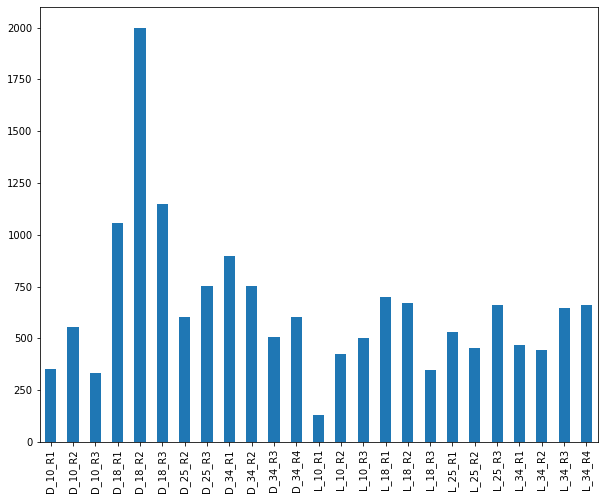

In [67]:
n_counts = pd.read_csv('Data/Dokdonia_transcripts_cell.csv', index_col=0)
ax = n_counts.dropna(axis=1).iloc[:,1:].sum().plot.bar(figsize=(10,8))

## Light vs dark conditions

## Across temperatures

In [3]:
DE_results = Dc.readFromPickleFile('Results/DE_result.pkl')
len(DE_results['all'])

1930

In [2]:
# Prepara plot data
p_Data_paths, cluster_data, clusters = {}, {}, {}
data_types = ['TC', 'TPM']
res_ids = ['CLUSTER_ALL_GENES_TRANSCRIPT_CELL', 'CLUSTER_ALL_GENES_TPM']

for data_type, res_id in zip(data_types, res_ids):
    
    p_KEGG_paths = Dc.readFromPickleFile(
        path_to_file=f'Results/Permutation_analysis/p_KEGG_paths_500000_{res_id}.pkl')
    p_PATRIC_paths = Dc.readFromPickleFile(
        path_to_file=f'Results/Permutation_analysis/p_PATRIC_paths_500000_{res_id}.pkl')
    c_data = pd.read_csv(os.path.join(
        os.getcwd(),f'Results/{res_id}/Processed_Data/clust_input.tsv_processed.tsv'),
                        sep='\t', index_col='Genes')
    # Add fake column to separate datasets
    c_data.insert(4, '', [np.nan for n in range(c_data.shape[0])])

    clusts = Dc.readFromPickleFile(path_to_file=f'Results/Clusters_{res_id}.pkl')
    clusts = {k: v for k,v in clusts.items() if k != 'No_cluster_assigned'}
    
    p_Data_paths[data_type] = {'KEGG': p_KEGG_paths, 'PATRIC': p_PATRIC_paths}
    cluster_data[data_type] = c_data
    clusters[data_type] = clusts

## Using the silhouette to rank genes within cluster

We can calculate the silhouette of each gene in a cluster to rank them based on how well they fit in the cluster. We can also use the silhouette to assess how good the clusters are.

From Wikipedia:

"The silhouette value is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). The silhouette ranges from −1 to +1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters."

The silhouette compares the mean within-cluster distance of a gene with that of inter-cluster (https://en.wikipedia.org/wiki/Silhouette_(clustering)) Described originally in the paper: https://www.sciencedirect.com/science/article/pii/0377042787901257

In [3]:
# Rank cluster genes by silhouettes
ranked_clusters = {}
data_types = ['TC', 'TPM']
res_ids = ['CLUSTER_ALL_GENES_TRANSCRIPT_CELL', 'CLUSTER_ALL_GENES_TPM']

for data_type, res_id in zip(data_types, res_ids):
   
    c_data = pd.read_csv(os.path.join(
        os.getcwd(),f'Results/{res_id}/Processed_Data/clust_input.tsv_processed.tsv'),
                        sep='\t', index_col='Genes')
    
    ranked_clusters[data_type] = Dc.rankGenesWithinClusters(clusters[data_type], c_data)

# Making Dokdonia-specific KEGG JSON

In [8]:
# Write Excel with cluster results

with open('Data/Function_Annotations/KEGG/Dokdonia_KEGG_pathways.json') as json_file:
    kegg_pathways = json.load(json_file)['children']
    
gbk = Dc.GenomeGBK('Data/DokdoniaMED134.gbk')
    
eggNOG = pd.read_excel('Data/Function_Annotations/KEGG/result_eggNOGMapper.xlsx', header=2)
ko_pathway_dict = Dc.getKEGGPathwayDict(kegg_pathways)
gene_ko_dict= Dc.getGeneKOs(eggNOG)

patric_features = pd.read_csv('Data/Function_Annotations/PATRIC/Dokdonia_MED134_Craig_PATRIC_genome_feature.csv')
patric_pathways = pd.read_csv('Data/Function_Annotations/PATRIC/Dokdonia_MED134_PATRIC_pathways.csv')
patric_pathways_genes = pd.read_csv('Data/Function_Annotations/PATRIC/Dokdonia_MED134_Craig_PATRIC_pathways_genes.csv')

Dc.writeExcelOfClusterGenes(ranked_clusters['TPM'], 'Results/TPM_clusters_genes_pathways.xlsx',
                        gbk, patric_features, patric_pathways_genes, patric_pathways,
                        gene_ko_dict, ko_pathway_dict)

Dc.writeExcelOfClusterGenes(ranked_clusters['TC'], 'Results/TC_clusters_genes_pathways.xlsx',
                        gbk, patric_features, patric_pathways_genes, patric_pathways,
                        gene_ko_dict, ko_pathway_dict)

## Analyzing which genes are across-temperature, DE (LTR test) within clusters

In [10]:
cluster_stats = {}
for data_type in data_types:
    total_genes_in_clusters = [g for cluster in clusters[data_type].values() for g in cluster]
    DE_genes_in_clusters = np.intersect1d(DE_results['all'].index, total_genes_in_clusters)
    cluster_stats[data_type] = {'total genes': len(total_genes_in_clusters),
                               'DE fraction': len(DE_genes_in_clusters)/len(total_genes_in_clusters)}
    
pd.DataFrame(cluster_stats)                                                                            

,TC,TPM
total genes,1052.000000,948.000000
DE fraction,0.908745,0.931435


In [11]:
cluster_stats = {}
for data_type in data_types:
    cluster_stats[data_type] = {}
    for cluster_id, cluster in clusters[data_type].items():
        cluster_stats[data_type][cluster_id] = {
            'total genes': len(cluster),
            'DE fraction': len(np.intersect1d(DE_results['all'].index,cluster))/len(cluster)
        }

In [26]:
Dc.getMetaMatrix(counts_T)

,lighting,temperature,replicate
D_10_R1,D,10,R1
D_10_R2,D,10,R2
D_10_R3,D,10,R3
D_34_R1,D,34,R1
D_34_R2,D,34,R2
D_34_R3,D,34,R3
D_34_R4,D,34,R4


In [18]:
cluster_stats['TC']['C6']

{'total genes': 75, 'DE fraction': 0.7733333333333333}

## Evaluating fold change in clusters Clusters $C_1$, $C_3$ and $C_2$, $C_5$.

Basically, I get that these genes are not DE according to  the Wald test in DeSeq2. However, data clearly shows a patter... DeSeq2 being very conservative?

In [62]:
p_value_cutoff = 0.05
fold_cutoff = k = 0.1

T1, T2 = 34, 25
counts_T = counts[counts.filter(regex=f'{T1}|{T2}|index').columns]
counts_T_C3 = counts_T[counts_T['index'].isin(clusters['TC']['C3'])]

T_res, T_stats = Dc.runDEtest(counts_T_C3, test='Wald', alpha=p_value_cutoff,
                                  formula='~ temperature', log2fold_cutoff=k)

In [63]:
T_res

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,index
MED134_04624,1239.139427,0.197042,0.015828,6.131097,8.727541e-10,1.274221e-08,MED134_04624
MED134_03499,2219.167085,0.185841,0.013400,6.406053,1.493354e-10,2.725371e-09,MED134_03499
MED134_07626,853.915948,0.418700,0.026521,12.017057,2.890864e-33,2.110330e-31,MED134_07626
MED134_10595,689.031967,0.206668,0.014264,7.478255,7.531590e-14,2.749030e-12,MED134_10595
MED134_11826,704.764486,0.132876,0.010406,3.159426,1.580803e-03,1.923310e-02,MED134_11826
MED134_11831,1004.845845,0.192995,0.013938,6.672189,2.520156e-11,6.132379e-10,MED134_11831


In [9]:
# Plotting both databases at the same time
Dc.plotSystemsAndSubsystemsWebPage(clusters, cluster_data, p_Data_paths,
                                   plot_first_N=10, color='#dd912d',
                                   img_folder_name='iplots_imgs')

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


# Will genes not assigned to clusters but within pathways showing a pattern also show a pattern?

In [3]:
#cluster_data['TC']
with open('Data/Function_Annotations/KEGG/Dokdonia_KEGG_pathways.json') as json_file:
    kegg_pathways = json.load(json_file)['children']
    
gbk = Dc.GenomeGBK('Data/DokdoniaMED134.gbk')
    
eggNOG = pd.read_excel('Data/Function_Annotations/KEGG/result_eggNOGMapper.xlsx', header=2)
ko_pathway_dict = Dc.getKEGGPathwayDict(kegg_pathways)
gene_ko_dict= Dc.getGeneKOs(eggNOG)

res_id = 'CLUSTER_ALL_GENES_TRANSCRIPT_CELL'

TC_clusters = Dc.readFromPickleFile(path_to_file=f'Results/Clusters_{res_id}.pkl')
#TC_clusters['No_cluster_assigned']

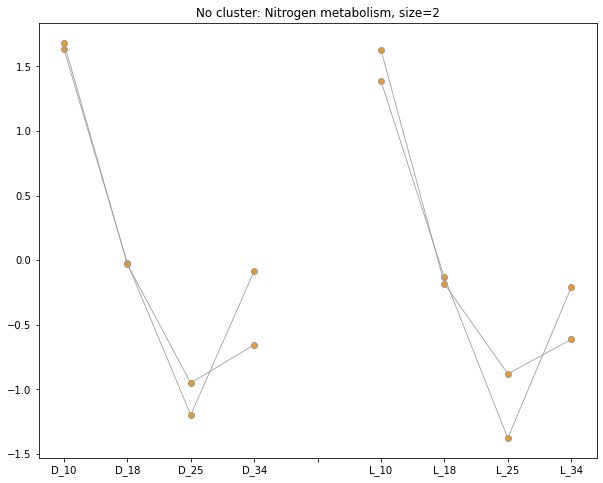

In [53]:
system = 'Nitrogen metabolism' #'Aminoacyl-tRNA biosynthesis'# 'Homologous recombination'#'Ribosome'
system_type = 'subsystem'
cluster_id = f'No cluster: {system}'
pathway_genes = Dc.getGenesInKEGGsystem(ko_pathway_dict, gene_ko_dict, system, system_type)
#no_cluster_genes = TC_clusters['No_cluster_assigned'] 
no_cluster_genes = clusters['TC']['C2']
no_cluster_genes_in_pathway = [gene_id 
                               for gene_id in no_cluster_genes
                               if gene_id in pathway_genes]
ax = plt.gca()
ax.figure.set_size_inches(10, 8)
Dc.plotClusterData(cluster_data['TC'], no_cluster_genes_in_pathway, ax, cluster_id)
plt.show()

In [54]:
pathway_genes_info = {
    'gene id': [],
    'product': [],
    'KEGG system': [],
    'KEGG subsystem': []
}

for gene_id in no_cluster_genes_in_pathway:
    pathways = Dc.getKEGGPathwaysForLocusTag(gene_id,
                                             gene_ko_dict,
                                             ko_pathway_dict)
    systems = ', '.join(pathways['system'])
    subsystems = ', '.join(pathways['subsystem'])
    
    pathway_genes_info['gene id'].append(gene_id)
    pathway_genes_info['product'].append(gbk.getGeneInfo(gene_id)['product'][0])
    pathway_genes_info['KEGG system'].append(systems)
    pathway_genes_info['KEGG subsystem'].append(subsystems)
    
pd.DataFrame(pathway_genes_info)

,gene id,product,KEGG system,KEGG subsystem
0,MED134_03484,glutamate-ammonia ligase,"09105 Amino acid metabolism, 09105 Amino acid ...","00220 Arginine biosynthesis [PATH:ko00220], 00..."
1,MED134_03489,glutamate-ammonia ligase,"09105 Amino acid metabolism, 09105 Amino acid ...","00220 Arginine biosynthesis [PATH:ko00220], 00..."


# Plotting overrepresented systems

In [32]:
cluster_match_TPM_TC = [
    ('C0', 'C4'), ('C1', 'C5'), 
    ('C2', 'C6'), ('C3', 'C1'),
    ('C4', 'C0'), ('C5', 'C2')
]

TC_cluster_colors =     {
        'C0': '#3d03fc', 'C1': '#036bfc', 'C2': '#03adfc',
        'C3': '#fc4e03', 'C4': '#fc0303', 'C5': '#fc7703', 
        'C6': '#03fc7b', 'No cluster': 'white'
    }

cluster_colors = {
    'TC': TC_cluster_colors,
    'TPM':
    {
        'C0': TC_cluster_colors['C4'], 'C1': TC_cluster_colors['C5'],
        'C2': TC_cluster_colors['C6'], 'C3': TC_cluster_colors['C1'],
        'C4': TC_cluster_colors['C0'], 'C5': TC_cluster_colors['C2'],
        'No cluster': 'white'
    }
}
    
Dc.plotSystemsAndSubsystemsStacked(p_Data_paths, cluster_colors, 'iplots_Stacked')

# Analyzing genes in pathways

What you have to do is to remove KEGG pathways that don't make sense in a prokaryote... most genes have redundant pathways assigned. So, remove Peroxisome, and perhaps other ones, like some signaling pathways.

In [84]:
gene_list = clusters['TC']['C3']


for gene_id in gene_list:
    g_info = gbk.getGeneInfo(gene_id)
    if 'note' in g_info.keys():
        if 'heat shock' in g_info['note'][0].lower():
            print(gene_id)
        

In [3]:
with open('Data/Function_Annotations/KEGG/kegg_pathways.json') as json_file:
    kegg_pathways = json.load(json_file)['children']
gbk = Dc.GenomeGBK('Data/DokdoniaMED134.gbk')

kegg_dict = Dc.assignSystemsToEnzymes(kegg_pathways)
eggNOG = pd.read_excel('Data/Function_Annotations/KEGG/result_eggNOGMapper.xlsx', header=2)
ko_pathway_dict = Dc.getKEGGPathwayDict(kegg_pathways)
gene_ko_dict= Dc.getGeneKOs(eggNOG)

The KEGG pathway Peroxisome doesn't make much sense in Dokdonia. Let's look at the genes that form this pathway

In [4]:
peroxigenes = Dc.getGenesInKEGGsystem(ko_pathway_dict, gene_ko_dict,
                                      'Peroxisome', system_type='subsystem')

[(gene_id, gbk.getGeneInfo(gene_id)['product'][0]) for gene_id in peroxigenes]

[('MED134_06289', 'hydroxymethylglutaryl-CoA lyase'),
 ('MED134_05414', 'long-chain-fatty-acid-CoA ligase'),
 ('MED134_04964', 'superoxide dismutase [Cu-Zn]'),
 ('MED134_01785', 'aminotransferase class-V'),
 ('MED134_09101', 'superoxide dismutase'),
 ('MED134_10845', 'mevalonate kinase'),
 ('MED134_14141', 'isocitrate dehydrogenase')]

In [11]:
subsystem_name = 'Peroxisome'
subsystem_genes = Dc.getGenesInKEGGsystem(ko_pathway_dict, gene_ko_dict,
                                          subsystem_name, system_type='subsystem')

total_genes = [(gene_id, gbk.getGeneInfo(gene_id)['product'][0]) 
               for gene_id in subsystem_genes]
genes_in_cluster = [(gene_id, gbk.getGeneInfo(gene_id)['product'][0]) 
                    for gene_id in subsystem_genes if gene_id in clusters['TC']['C0']]

print(total_genes)
print(genes_in_cluster)

[('MED134_06289', 'hydroxymethylglutaryl-CoA lyase'), ('MED134_05414', 'long-chain-fatty-acid-CoA ligase'), ('MED134_04964', 'superoxide dismutase [Cu-Zn]'), ('MED134_01785', 'aminotransferase class-V'), ('MED134_09101', 'superoxide dismutase'), ('MED134_10845', 'mevalonate kinase'), ('MED134_14141', 'isocitrate dehydrogenase')]
[]


# Clustering data merging day and dark counts

There are little differences between dark and light conditions across temperatures. Thus, it seems unnecessary to do clusters on these two separate datasets. Instead, we could take only dark or only light conditions, or obtain the average across temperatures among these two conditions. Taking the average, however, implies loosing the variability contained in the replicates, since we would had to first average over replicates in light and dark, and the average again between light and dark. To solve this issue, we can treat light and dark conditions as additional replicates of each temperature, and then run the clustering algorithm. Let's go for that.

In [2]:
# Loading Transcript/Cell data and scale up data
n_counts = pd.read_csv('Data/Dokdonia_transcripts_cell.csv', index_col=0)
n_counts.iloc[:,1:] = 1e4 * n_counts.iloc[:,1:]

clust_data_TC = n_counts
clust_data_TC = clust_data_TC[clust_data_TC.filter(regex='^[^T]+$').columns]
clust_data_TC = clust_data_TC.set_index('index')
clust_data_TC.index.name = 'ID'
clust_data_TC = clust_data_TC.dropna(axis=1)

clust_data_TC.head()

,D_10_R1,D_10_R2,D_10_R3,D_18_R1,D_18_R2,D_18_R3,D_25_R2,D_25_R3,D_34_R1,D_34_R2,...,L_18_R1,L_18_R2,L_18_R3,L_25_R1,L_25_R2,L_25_R3,L_34_R1,L_34_R2,L_34_R3,L_34_R4
ID,,,,,,,,,,,,,,,,,,,,,
MED134_07389,3272.742595,4023.255679,3193.191427,15046.001051,25885.970883,18162.634520,12525.337743,13779.248042,17241.568322,14585.675293,...,10636.784088,10242.042265,6006.706745,11627.525559,10910.352316,14970.913156,8945.846865,9695.256532,12718.703565,14741.535906
MED134_07384,392.789657,547.537422,373.996913,2043.866391,3707.295784,2474.589206,1744.778890,1898.573010,2530.246196,2081.393024,...,1443.568271,1615.539610,753.315530,1597.443490,1447.705242,2150.602814,1217.079060,1486.691533,1997.787565,1992.760793
MED134_07379,857.729502,1168.666690,788.719005,3546.304715,6681.586906,4224.249541,2930.021236,3699.854578,4502.661370,3607.912641,...,2381.739097,2882.641856,1344.830021,2679.306861,2357.751168,3449.133396,2295.894691,2383.525449,3360.106180,3524.418456
MED134_07374,501.267212,747.890343,338.332259,1724.020954,3189.035279,1920.596526,1283.141894,1520.526262,1628.184006,1433.720402,...,1195.986244,1132.894001,641.685356,1057.101376,939.857775,1410.549570,937.845577,968.805933,1222.916402,1356.800422
MED134_07369,526.494550,707.749336,508.703275,1854.219173,3220.316908,1986.579667,1337.315556,1377.021384,1904.745799,1451.017297,...,1445.548927,1603.567983,866.952537,1092.180869,1087.347977,1520.546555,1244.596415,1114.940420,1264.876934,1312.703771


In [23]:
# Cluster genes
res_id = 'CLUSTER_ALL_GENES_MERGED_L_D_TRANSCRIPT_CELL'
print(f'Running condition: {res_id}')
workdir = os.path.join(os.getcwd(),'Results')
clust_tightness = 2

clusters = Dc.getGeneClusters(clust_data_TC, path_to_wd=workdir, 
                              out_dir=os.path.join(workdir, res_id),
                              cluster_tightness=clust_tightness,
                              replicates_file='clust_replicates_merged_L_D.txt',
                              normalization_file='clust_TPM_normalization.txt')


# Obtain genes without assigned cluster
gene_ids = list(clust_data_TC.index)
genes_in_cluster = [gene for gene_ids in clusters.values() for gene in gene_ids]
genes_without_cluster = np.setdiff1d(gene_ids, genes_in_cluster).tolist()
clusters['No_cluster_assigned'] = genes_without_cluster

Running condition: CLUSTER_ALL_GENES_MERGED_L_D_TRANSCRIPT_CELL


In [24]:
{c_id: len(c) for c_id, c in clusters.items()}

{'C0': 420,
 'C1': 176,
 'C2': 131,
 'C3': 87,
 'C4': 152,
 'C5': 412,
 'C6': 165,
 'C7': 84,
 'C8': 155,
 'C9': 27,
 'No_cluster_assigned': 1068}

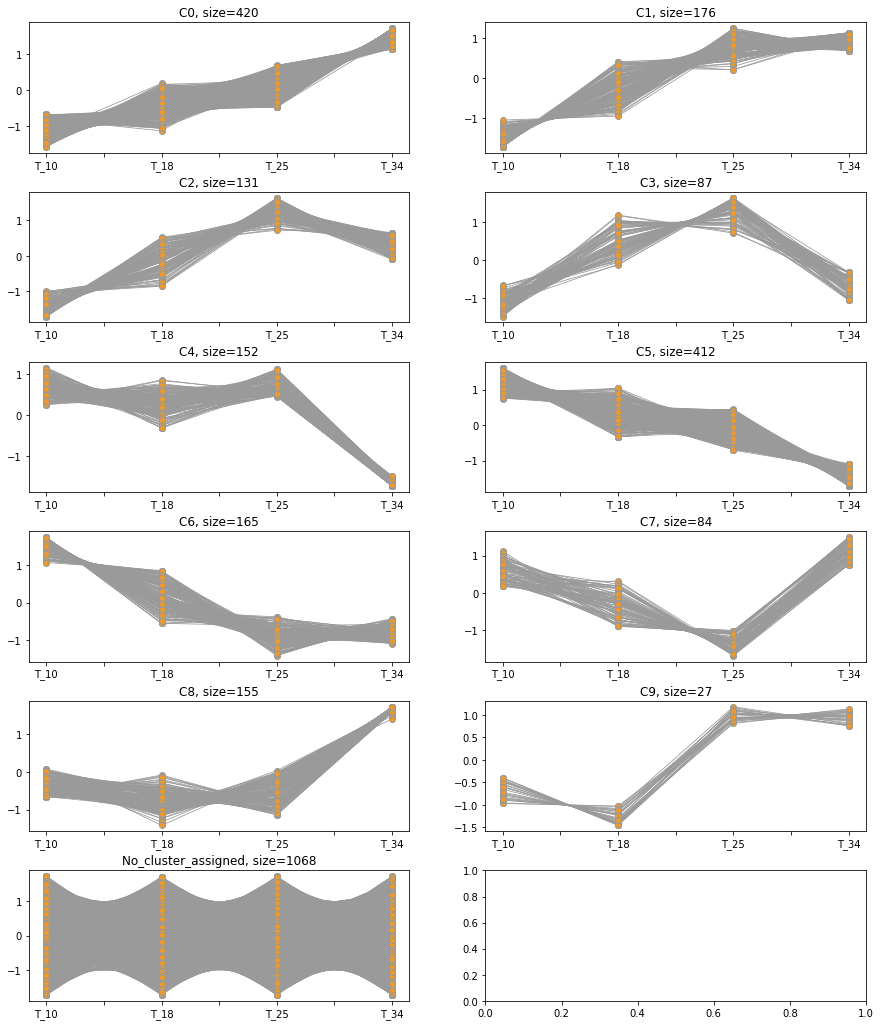

In [25]:
cluster_data = pd.read_csv(os.path.join(
    os.getcwd(),f'../Proyecto_rodopsina/Results/{res_id}/Processed_Data/clust_input.tsv_processed.tsv'),
                    sep='\t', index_col='Genes')
# Add fake column to separate datasets
cluster_data.insert(4, '', [np.nan for n in range(cluster_data.shape[0])])

Dc.plotClusters(cluster_data, clusters)

# Clustering only data from condition Dark...

Running condition: CLUSTER_ALL_GENES_ONLY_D_TRANSCRIPT_CELL


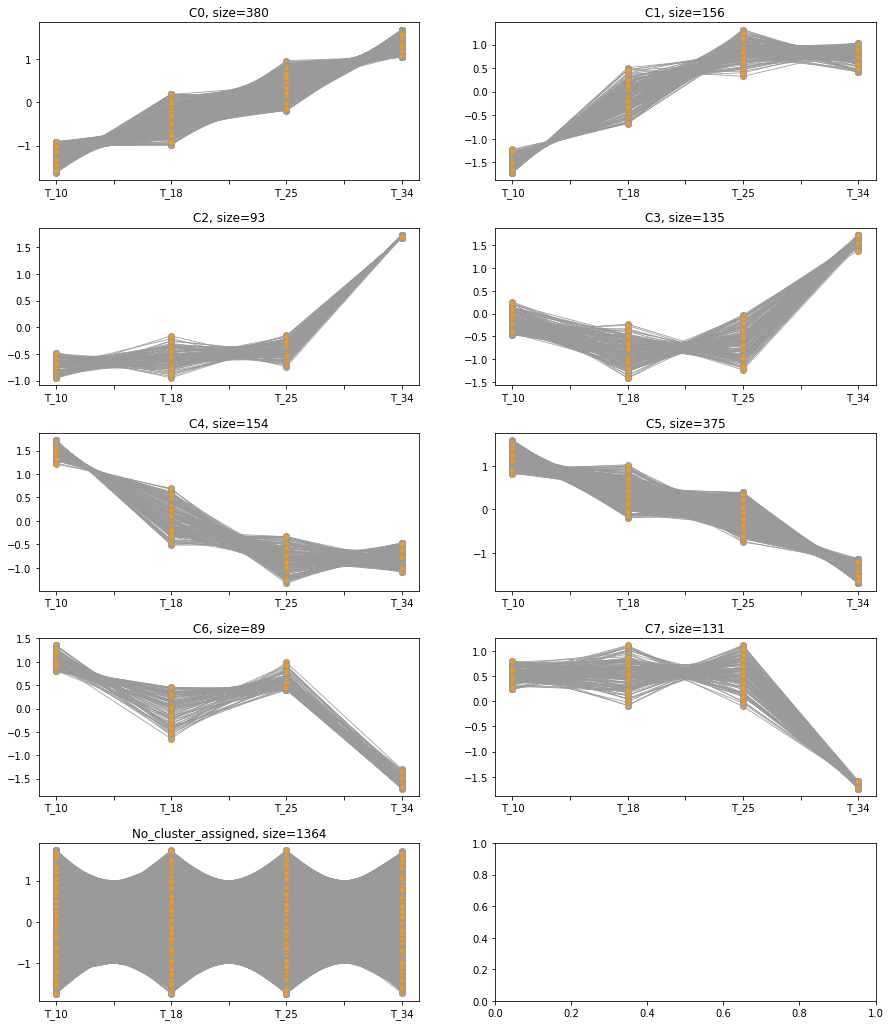

In [29]:
# Cluster genes
res_id = 'CLUSTER_ALL_GENES_ONLY_D_TRANSCRIPT_CELL'
print(f'Running condition: {res_id}')
workdir = os.path.join(os.getcwd(),'Results')
clust_tightness = 5

clusters = Dc.getGeneClusters(clust_data_TC, path_to_wd=workdir, 
                              out_dir=os.path.join(workdir, res_id),
                              cluster_tightness=clust_tightness,
                              replicates_file='clust_replicates_only_D.txt',
                              normalization_file='clust_TPM_normalization.txt')


# Obtain genes without assigned cluster
gene_ids = list(clust_data_TC.index)
genes_in_cluster = [gene for gene_ids in clusters.values() for gene in gene_ids]
genes_without_cluster = np.setdiff1d(gene_ids, genes_in_cluster).tolist()
clusters['No_cluster_assigned'] = genes_without_cluster

cluster_data = pd.read_csv(os.path.join(
    os.getcwd(),f'../Proyecto_rodopsina/Results/{res_id}/Processed_Data/clust_input.tsv_processed.tsv'),
                    sep='\t', index_col='Genes')
# Add fake column to separate datasets
cluster_data.insert(4, '', [np.nan for n in range(cluster_data.shape[0])])

Dc.plotClusters(cluster_data, clusters)

# Clustering only data from condition Light...

Running condition: CLUSTER_ALL_GENES_ONLY_L_TRANSCRIPT_CELL


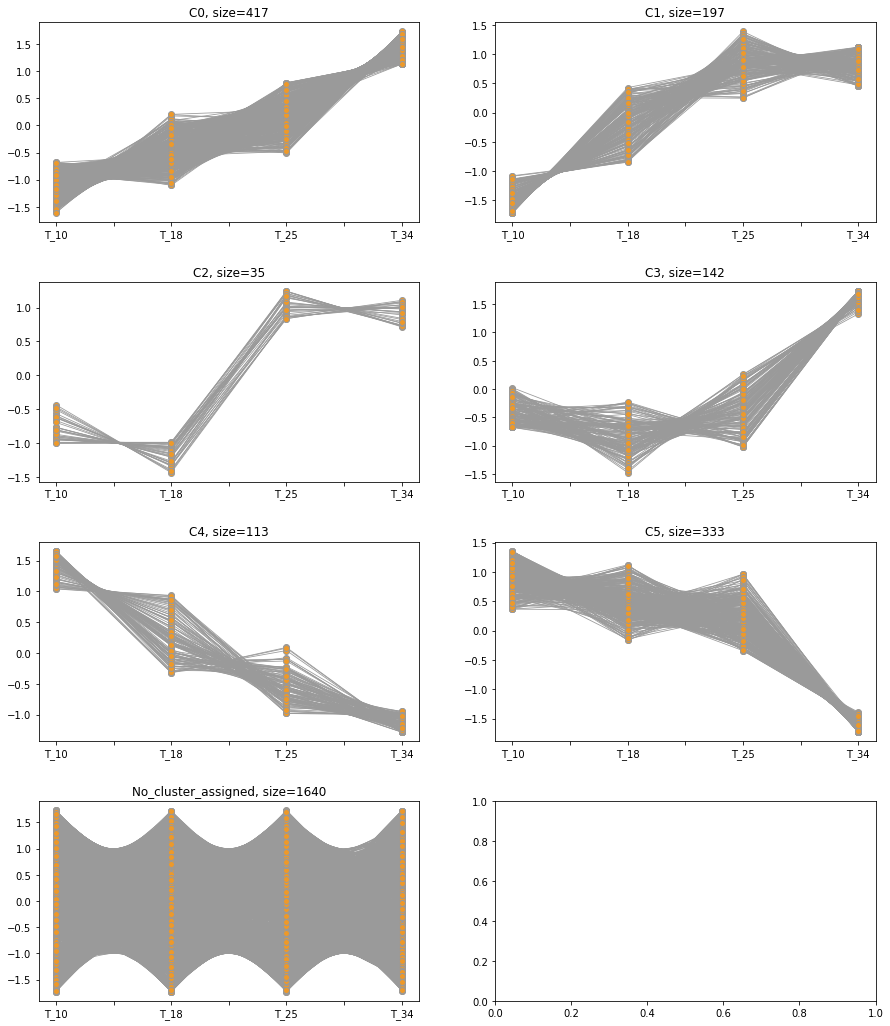

In [30]:
# Cluster genes
res_id = 'CLUSTER_ALL_GENES_ONLY_L_TRANSCRIPT_CELL'
print(f'Running condition: {res_id}')
workdir = os.path.join(os.getcwd(),'Results')
clust_tightness = 5

clusters = Dc.getGeneClusters(clust_data_TC, path_to_wd=workdir, 
                              out_dir=os.path.join(workdir, res_id),
                              cluster_tightness=clust_tightness,
                              replicates_file='clust_replicates_only_L.txt',
                              normalization_file='clust_TPM_normalization.txt')


# Obtain genes without assigned cluster
gene_ids = list(clust_data_TC.index)
genes_in_cluster = [gene for gene_ids in clusters.values() for gene in gene_ids]
genes_without_cluster = np.setdiff1d(gene_ids, genes_in_cluster).tolist()
clusters['No_cluster_assigned'] = genes_without_cluster

cluster_data = pd.read_csv(os.path.join(
    os.getcwd(),f'../Proyecto_rodopsina/Results/{res_id}/Processed_Data/clust_input.tsv_processed.tsv'),
                    sep='\t', index_col='Genes')
# Add fake column to separate datasets
cluster_data.insert(4, '', [np.nan for n in range(cluster_data.shape[0])])

Dc.plotClusters(cluster_data, clusters)